In [ ]:
# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
!pwd

/content


In [ ]:
os.chdir('/content/drive/My Drive/PyTorch')

In [ ]:
# import required modules
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import datetime
import matplotlib.pyplot as plt
from torchsummary import summary
import sklearn.metrics
import seaborn as sns
from collections import OrderedDict

In [ ]:
cd /content/drive/My Drive/PyTorch/data

/content/drive/My Drive/PyTorch/data


In [ ]:
# set random seed to get reproducible results
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
# Image processing
transform = transforms.Compose([ #torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                #torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                transforms.ToTensor(),
                                #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
                                ])
print(transform)

Compose(
    ToTensor()
)


In [ ]:
%%time
# take dataset from folders and split it into train, validation and test sets

# set paths
train_data_dir = 'cifar10/train/' # put path of training dataset
test_data_dir = 'cifar10/test/' # put path of test dataset

# Load Images

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

print('number of images in train set =',len(trainset))
print('trainset class-indices =',trainset.classes)
print('number of images in test set =',len(testset))
print('trainset class-indices =',testset.classes)

number of images in train set = 50000
trainset class-indices = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number of images in test set = 10000
trainset class-indices = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CPU times: user 218 ms, sys: 17.9 ms, total: 236 ms
Wall time: 2min 29s


In [ ]:
# Class names
classes = testset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# visualise a batch
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl: # here in single iteration images contains 128 images and labels contain 128 labels
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0)) # 16 columns
        break # we are breaking out with one iteration

CPU times: user 30.1 ms, sys: 37.6 ms, total: 67.7 ms
Wall time: 23.9 s


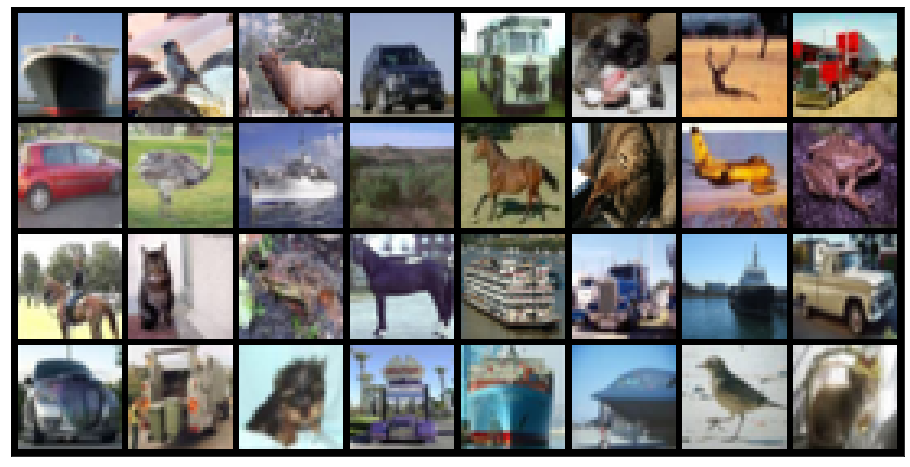

In [ ]:
%%time
# let's visualise a single trainset batch
show_batch(trainloader)

In [ ]:
# Helper class and functions to use GPU
# Code to use GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Base Model
# Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,f):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        datetime_object = datetime.datetime.now()

        f.write(str(datetime_object)+" - "+"Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f} \n".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'])) 

In [ ]:
# Get the device name
device = get_default_device()
device

device(type='cuda')

In [ ]:
# load dataset to device
train_loader = DeviceDataLoader(trainloader, device)
test_loader = DeviceDataLoader(testloader, device)

In [ ]:
# Saliency Maps

In [ ]:
# to get probability of true label
def true_label_probab(img, label, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    yb = F.softmax(yb)
    # Pick index with true label probability
    preds  = yb[0][label]
    # Retrieve the class label
    return preds.item()

In [ ]:
# This is the perfect and right code
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            #print(h, w)
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            prob = true_label_probab(input_image, label, model)
            

            heatmap[h, w] = prob 

    return heatmap

In [ ]:
# function to plot a given image
def show_image(image, label):
  print('label:', testset.classes[label], 'class: ',label)
  return image.permute(1,2,0)

In [ ]:
def plot_saliency(model, image, label):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
  ax1.imshow(show_image(image,label))
  to_device(model, device)
  heatmap = occlusion(model, image, label, occ_size = 12, occ_stride = 1, occ_pixel = 0.5)
  ax2.matshow(heatmap)
  plt.show()

In [ ]:
cf = 0

In [ ]:
# Models

In [ ]:
# simple cnn model without CBAM
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg','max'], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        spatial_att = self.SA(channel_att)

        return spatial_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
label: airplane class:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


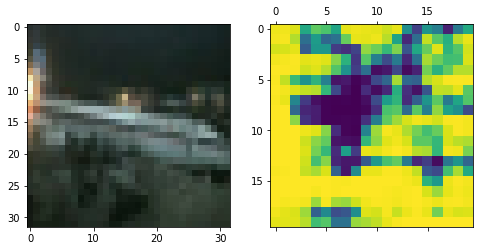

label: automobile class:  1


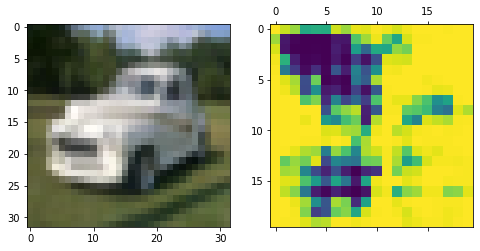

label: bird class:  2


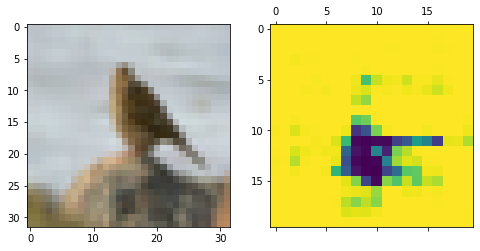

label: cat class:  3


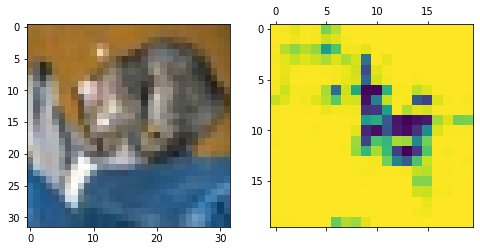

label: deer class:  4


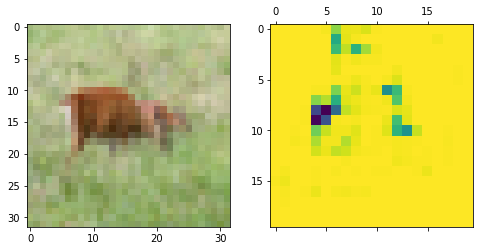

label: dog class:  5


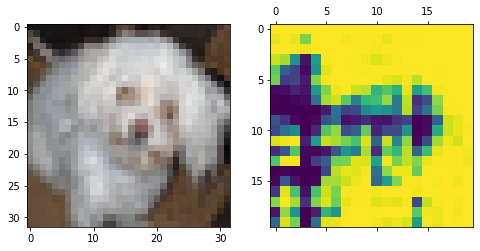

label: frog class:  6


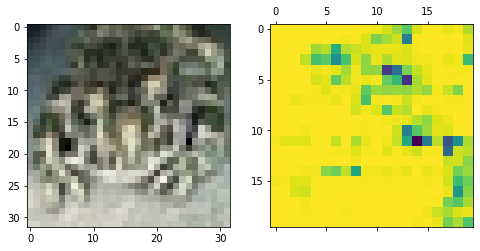

label: horse class:  7


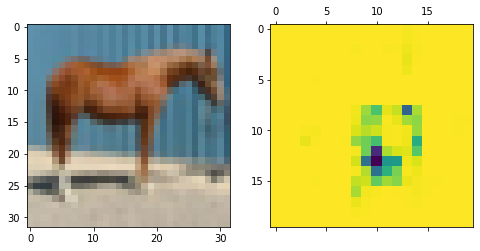

label: ship class:  8


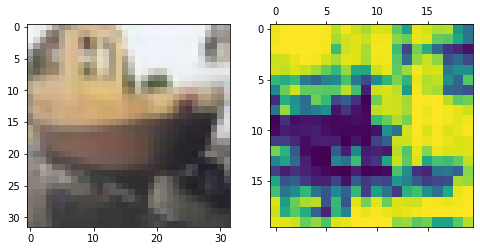

label: truck class:  9


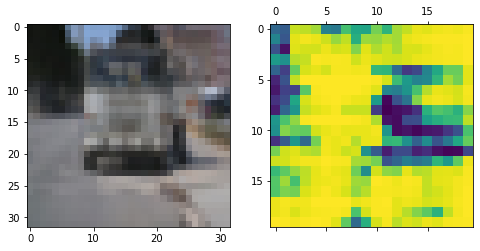

In [ ]:
# simple cnn model without CBAM
model = SimpleCNN()
model.load_state_dict(torch.load('simplecnn.pth', map_location=torch.device('cpu')), strict=False)
model.eval()
to_device(model, device)
for i in range(0,10000,1000):
  image, label = testset[i+cf]
  plot_saliency(model, image, label)

Model Complete
label: airplane class:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


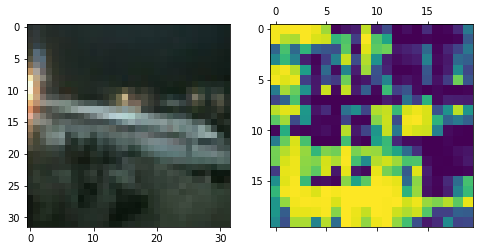

label: automobile class:  1


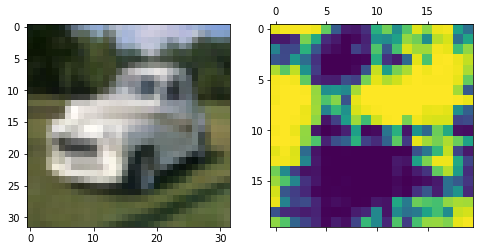

label: bird class:  2


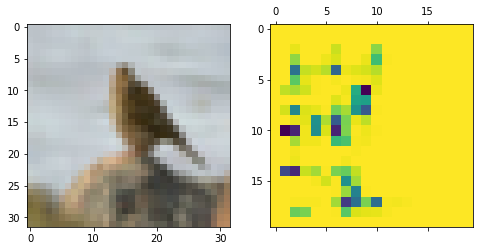

label: cat class:  3


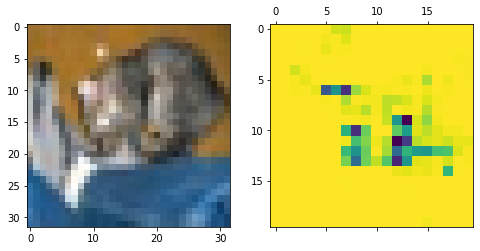

label: deer class:  4


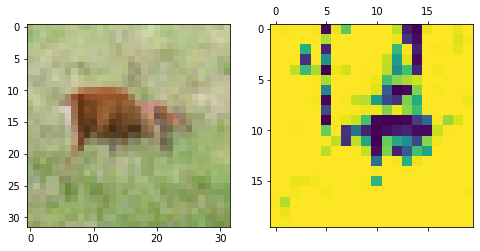

label: dog class:  5


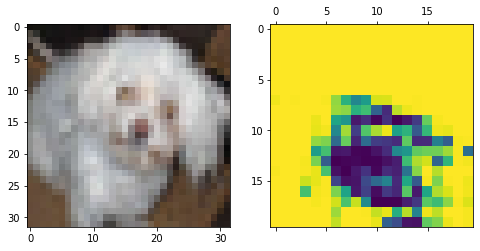

label: frog class:  6


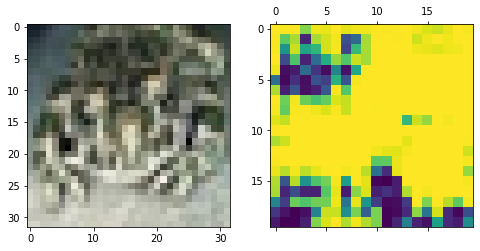

label: horse class:  7


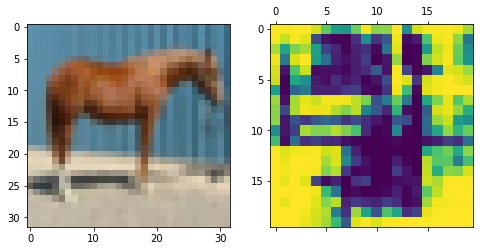

label: ship class:  8


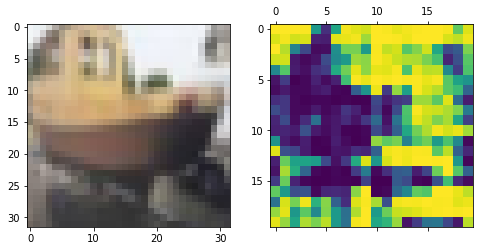

label: truck class:  9


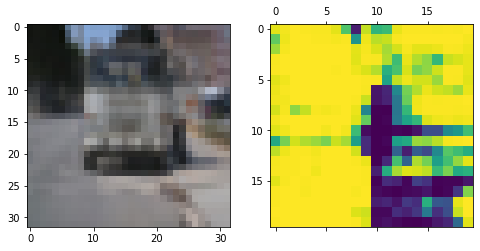

In [ ]:
# simple cnn with cbam with channel and spatial attn in series
model = SimpleCNN('CBAM')
model.load_state_dict(torch.load('simplecbam.pth', map_location=torch.device('cpu')), strict=False)
model.eval()
to_device(model, device)
for i in range(0,10000,1000):
  image, label = testset[i+cf]
  plot_saliency(model, image, label)

In [ ]:
# simple cnn with cbam with only channel attn
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        #spatial_att = self.SA(channel_att)

        return channel_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
label: airplane class:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


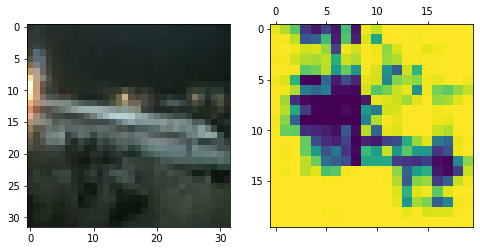

label: automobile class:  1


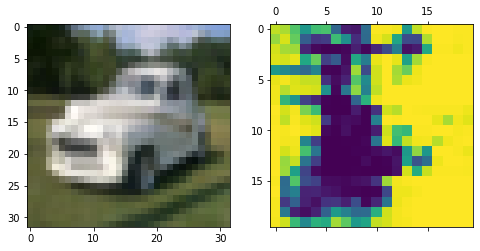

label: bird class:  2


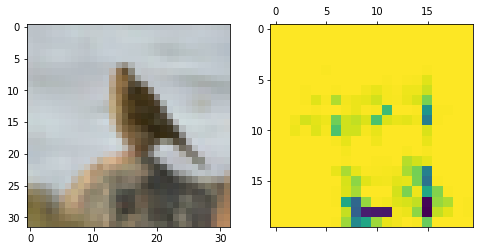

label: cat class:  3


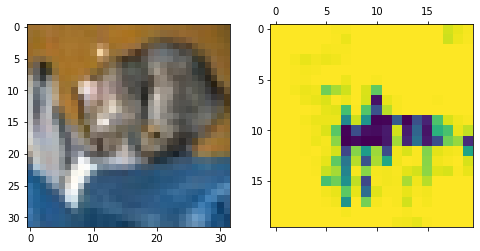

label: deer class:  4


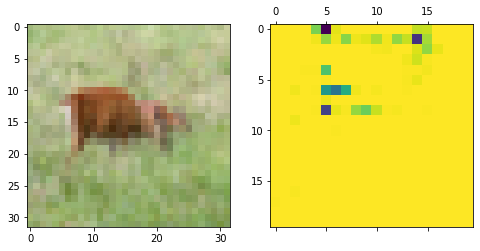

label: dog class:  5


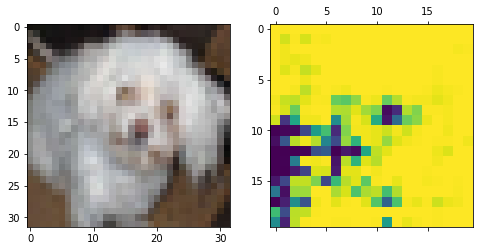

label: frog class:  6


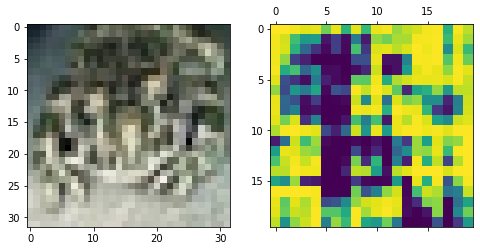

label: horse class:  7


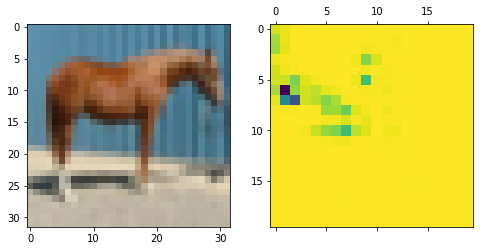

label: ship class:  8


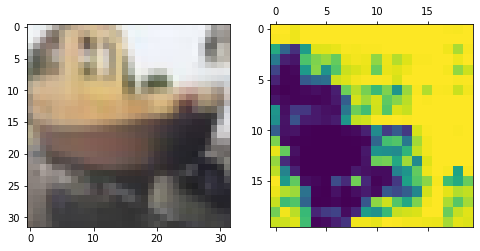

label: truck class:  9


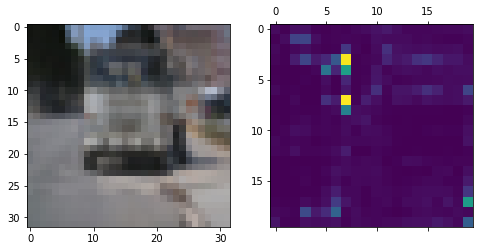

In [ ]:
# simple cnn with cbam with only channel attn
model = SimpleCNN('CBAM')
model.load_state_dict(torch.load('simplecbamonlychannel.pth', map_location=torch.device('cpu')), strict=False)
model.eval()
to_device(model, device)
for i in range(0,10000,1000):
  image, label = testset[i+cf]
  plot_saliency(model, image, label)

In [ ]:
# simple cnn with cbam with only spatial attn
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        #channel_att = self.CA(x)
        spatial_att = self.SA(x)

        return spatial_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
label: airplane class:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


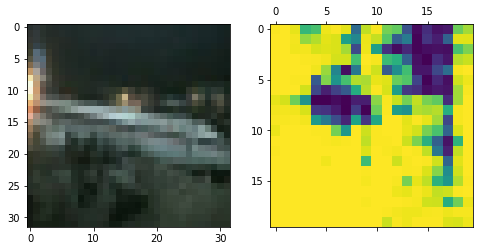

label: automobile class:  1


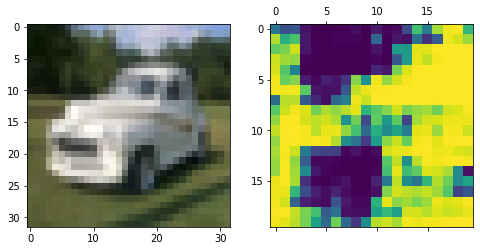

label: bird class:  2


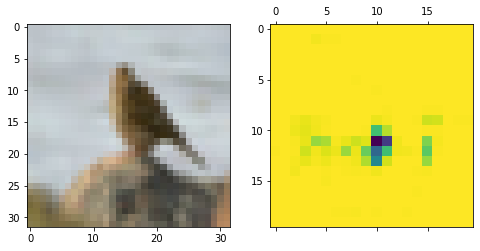

label: cat class:  3


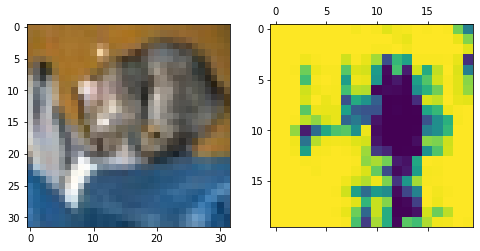

label: deer class:  4


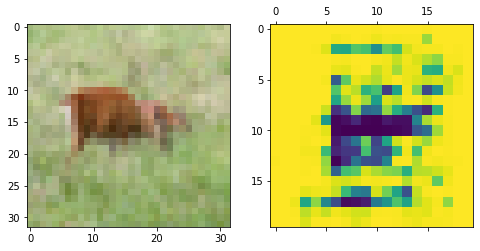

label: dog class:  5


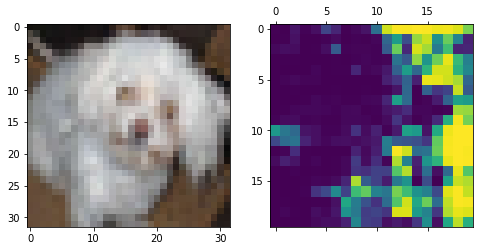

label: frog class:  6


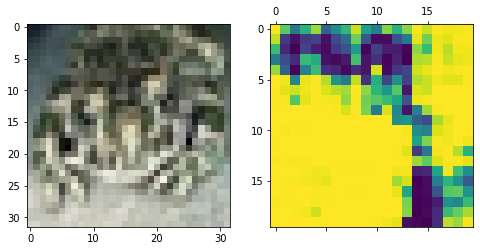

label: horse class:  7


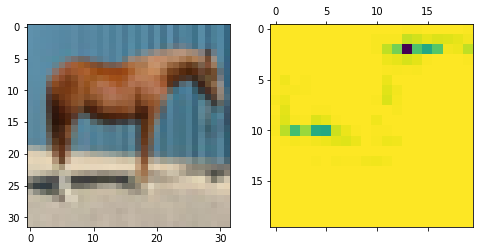

label: ship class:  8


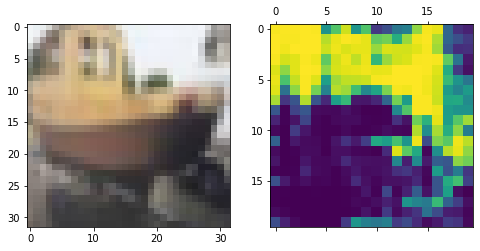

label: truck class:  9


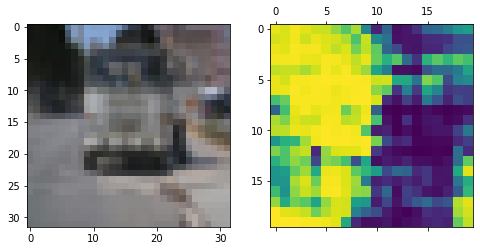

In [ ]:
# simple cnn with cbam with only spatial attn
model = SimpleCNN('CBAM')
model.load_state_dict(torch.load('simplecbamonlyspatial.pth', map_location=torch.device('cpu')), strict=False)
model.eval()
to_device(model, device)
for i in range(0,10000,1000):
  image, label = testset[i+cf]
  plot_saliency(model, image, label)

In [ ]:
# simple cnn with cbam with spatial and channel attn in parallel
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio, pool_types):
        super(ChannelAttention, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels//reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels//reduction_ratio, in_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None 
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool.view(avg_pool.size(0), -1))
            elif pool_type=='max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool.view(max_pool.size(0), -1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        channel_att = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * channel_att


class SpatialAttention(nn.Module):
    def __init__(self, k_size):
        super(SpatialAttention, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=k_size, padding=(k_size - 1)//2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        conv_concat = torch.cat((x.max(1)[0].unsqueeze(1), x.mean(1).unsqueeze(1)), dim=1)
        spatial_att_raw = self.conv_block(conv_concat)
        spatial_att = torch.sigmoid(spatial_att_raw).expand_as(x)
        return x * spatial_att


class CBAM(nn.Module):
    def __init__(self, in_channels, pool_types=['avg',"max"], k_size=7, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.CA = ChannelAttention(in_channels, reduction_ratio, pool_types)
        self.SA = SpatialAttention(k_size)
        
    def forward(self, x):
        channel_att = self.CA(x)
        spatial_att = self.SA(x)

        return channel_att+spatial_att

class SimpleCNN(ImageClassificationBase):
    def __init__(self, attention=None):
        super(SimpleCNN, self).__init__()
        # attention method
        self.attention = attention 
        # nb_channel and FCN size
        in_channels = 3
        fcn_size = 128*4*4
        
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

        self.features = nn.Sequential(
            # layer1
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),

            # layer2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
 
            # layer3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=fcn_size, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )

        # Attention Modules
        if attention=='CBAM':
            ch_lst = [32,64,128]
            for i in range(3):
                self.__setattr__('cbam%d' % i, CBAM(ch_lst[i]))

        print('Model Complete')

    
    def forward(self, x):
        nb_layer = 0
        for _, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            elif isinstance(layer, nn.BatchNorm2d) and (self.attention=='CBAM'): # CBAM
                x = self.__getattr__('cbam%d' % nb_layer)(x)
                x = layer(x)
                nb_layer += 1
            else:
                x = layer(x)

        x = x.view(x.size(0), -1)
        output = self.classifier(x)

        return output

Model Complete
label: airplane class:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


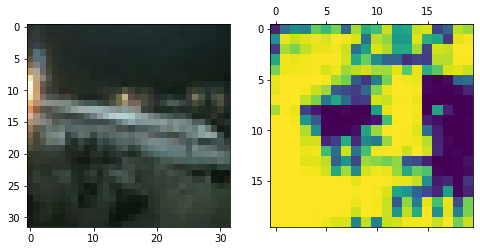

label: automobile class:  1


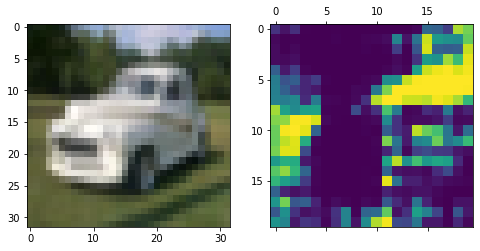

label: bird class:  2


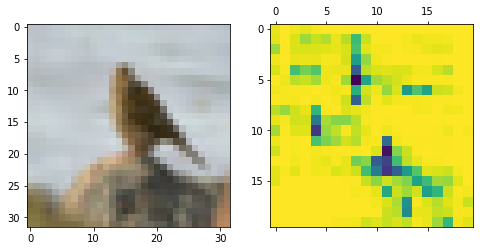

label: cat class:  3


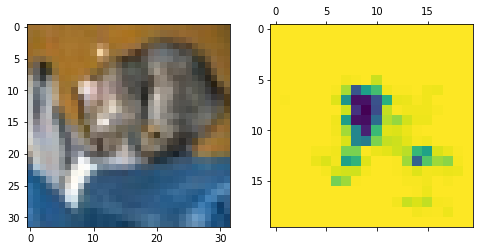

label: deer class:  4


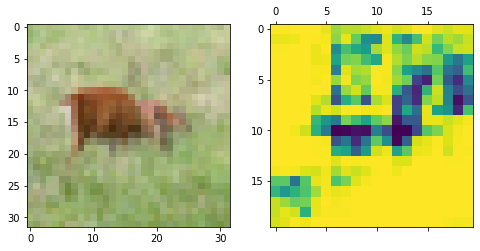

label: dog class:  5


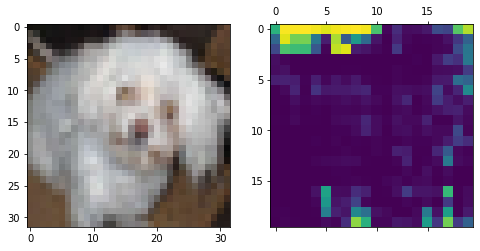

label: frog class:  6


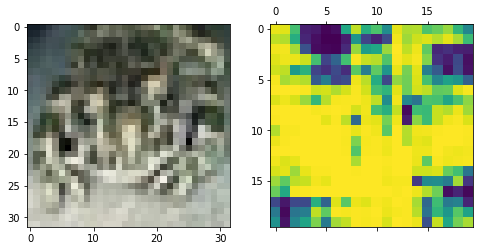

label: horse class:  7


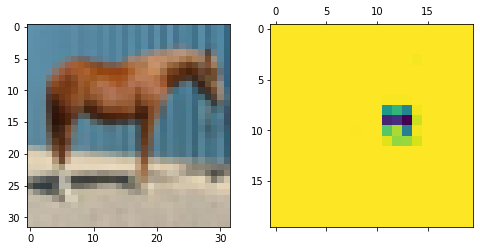

label: ship class:  8


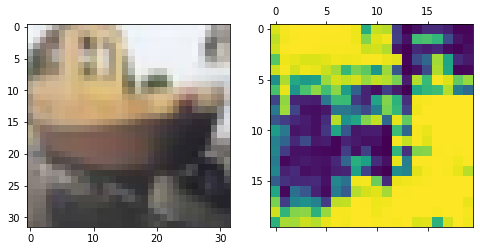

label: truck class:  9


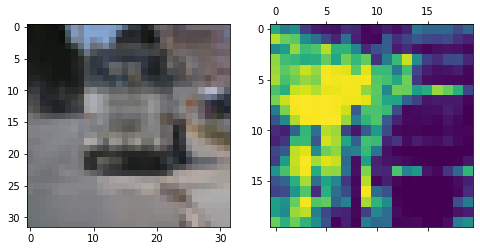

In [ ]:
# simple cnn with cbam with spatial and channel attn in parallel
model = SimpleCNN('CBAM')
model.load_state_dict(torch.load('simplecbamparallel.pth', map_location=torch.device('cpu')), strict=False)
model.eval()
to_device(model, device)
for i in range(0,10000,1000):
  image, label = testset[i+cf]
  plot_saliency(model, image, label)